Analyzing all fit_loss files...
Found 1 fit_loss CSV files

ANALYZING: Unknown with Dropout Unknown
File: fit_loss_training_data.csv
Data summary:
  Sample size: 150
  Original data range: [0.000245, 0.762170]
  Log-transformed: μ̂=-4.2929, σ̂=1.4759
  ✅ QQ plot saved to: qq_plots_tinybert\qq_plot_Unknown_dropout_Unknown.png


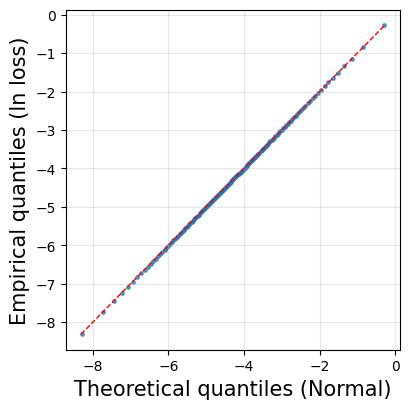


Kolmogorov-Smirnov Test:
  D = 0.0044, p-value = 1
  Decision @5%: Accept normality hypothesis

Anderson-Darling Test:
  A² = 0.0081
     15.0% significance: critical = 0.5620, decision = Accept
     10.0% significance: critical = 0.6400, decision = Accept
      5.0% significance: critical = 0.7670, decision = Accept
      2.5% significance: critical = 0.8950, decision = Accept
      1.0% significance: critical = 1.0650, decision = Accept

Shapiro-Wilk Test:
  W = 0.9997, p-value = 1
  Decision @5%: Accept normality hypothesis

Model Comparison (AIC/BIC):
  AIC:  LogNormal = -741.4,  Gamma = -701.8
  BIC:  LogNormal = -735.4,  Gamma = -695.8
  Better fit: AIC favors LogNormal, BIC favors LogNormal

✅ Saved analysis summary to: results_imdb_tinybert_TF_20250721_162029\distribution_analysis_summary.csv

✅ All QQ plots saved to directory: qq_plots_tinybert


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy import stats
import glob

def analyze_fit_loss_distribution(csv_path, plot_title=None, save_plots=True, output_dir='qq_plots'):
   
   
    try:
        df = pd.read_csv(csv_path)
        if 'fit_loss_training' not in df.columns:
            raise ValueError(f"Column 'fit_loss_training' not found in {csv_path}")
        
        train_losses = df['fit_loss_training'].values
        model_name = df['model_name'].iloc[0] if 'model_name' in df.columns else "Unknown"
        dropout_rate = df['dropout_rate'].iloc[0] if 'dropout_rate' in df.columns else "Unknown"
        
    except Exception as e:
        print(f"Error reading {csv_path}: {e}")
        return None
    
    print(f"\n{'='*60}")
    print(f"ANALYZING: {model_name} with Dropout {dropout_rate}")
    print(f"File: {os.path.basename(csv_path)}")
    print(f"{'='*60}")
    
   
    y = np.log(train_losses + 1e-10)  # Add small constant to avoid log(0)
    mu_hat, sigma_hat = np.mean(y), np.std(y, ddof=0)
    
    print(f"Data summary:")
    print(f"  Sample size: {len(train_losses)}")
    print(f"  Original data range: [{np.min(train_losses):.6f}, {np.max(train_losses):.6f}]")
    print(f"  Log-transformed: μ̂={mu_hat:.4f}, σ̂={sigma_hat:.4f}")
    
   
    n = y.size
    p = (np.arange(1, n+1) - 0.5)/n
    theory = stats.norm.ppf(p, loc=mu_hat, scale=sigma_hat)
    emp = np.sort(y)
    
    plt.figure(figsize=(4.2, 4.2))
    plt.scatter(theory, emp, s=6, alpha=0.7)
    lims = [min(np.min(theory), np.min(emp)), max(np.max(theory), np.max(emp))]
    plt.plot(lims, lims, 'r--', lw=1)  # 45° line
    plt.xlabel("Theoretical quantiles (Normal)",fontsize=15)
    plt.ylabel("Empirical quantiles (ln loss)",fontsize=15)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
   
    if save_plots:
      
        os.makedirs(output_dir, exist_ok=True)
        safe_model_name = str(model_name).replace(' ', '_').replace('-', '').replace('/', '_')
        safe_dropout = str(dropout_rate).replace('.', '_')
        plot_filename = f"qq_plot_{safe_model_name}_dropout_{safe_dropout}.png"
        plot_path = os.path.join(output_dir, plot_filename)
        
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"  QQ plot saved to: {plot_path}")
    
    plt.show()
    
    
    z = (y - mu_hat)/sigma_hat
    ks_stat, ks_p = stats.kstest(z, 'norm') 
    print(f"\nKolmogorov-Smirnov Test:")
    print(f"  D = {ks_stat:.4f}, p-value = {ks_p:.4g}")
    print(f"  Decision @5%: {'Accept' if ks_p > 0.05 else 'Reject'} normality hypothesis")
    
   
    ad = stats.anderson(y, dist='norm')  
    print(f"\nAnderson-Darling Test:")
    print(f"  A² = {ad.statistic:.4f}")
    
    passed_ad_5 = False
    for i, sl in enumerate(ad.significance_level):
        cv = ad.critical_values[i]
        decision = "Accept" if ad.statistic < cv else "Reject"
        print(f"    {sl:>5.1f}% significance: critical = {cv:.4f}, decision = {decision}")
        if sl == 5.0:
            passed_ad_5 = ad.statistic < cv
    
    sw_result = None
    if n <= 5000:  
        sw_stat, sw_p = stats.shapiro(y)
        sw_result = {'statistic': sw_stat, 'p_value': sw_p}
        print(f"\nShapiro-Wilk Test:")
        print(f"  W = {sw_stat:.4f}, p-value = {sw_p:.4g}")
        print(f"  Decision @5%: {'Accept' if sw_p > 0.05 else 'Reject'} normality hypothesis")
    else:
        print(f"\nShapiro-Wilk Test: Skipped (n={n} > 5000)")
    
   
    L = np.exp(y)
    
    print(f"\nModel Comparison (AIC/BIC):")
    
    # LogNormal log-likelihood (with MLE mu_hat, sigma_hat)
    try:
        ll_logn = np.sum(stats.lognorm(s=sigma_hat, scale=np.exp(mu_hat)).logpdf(L))
    except:
        ll_logn = -np.inf
        print("  Warning: LogNormal likelihood calculation failed")
    
   
    try:
        gamma_fit = stats.gamma.fit(L, floc=0) 
        ll_gamma = np.sum(stats.gamma(*gamma_fit).logpdf(L))
    except:
        ll_gamma = -np.inf
        gamma_fit = None
        print("  Warning: Gamma fit failed")
    
    k_params = 2  
    
    if np.isfinite(ll_logn) and np.isfinite(ll_gamma):
        AIC_logn = 2*k_params - 2*ll_logn
        AIC_gam = 2*k_params - 2*ll_gamma
        BIC_logn = k_params*np.log(n) - 2*ll_logn
        BIC_gam = k_params*np.log(n) - 2*ll_gamma
        
        print(f"  AIC:  LogNormal = {AIC_logn:.1f},  Gamma = {AIC_gam:.1f}")
        print(f"  BIC:  LogNormal = {BIC_logn:.1f},  Gamma = {BIC_gam:.1f}")
        
        better_aic = "LogNormal" if AIC_logn < AIC_gam else "Gamma"
        better_bic = "LogNormal" if BIC_logn < BIC_gam else "Gamma"
        print(f"  Better fit: AIC favors {better_aic}, BIC favors {better_bic}")
    else:
        AIC_logn = AIC_gam = BIC_logn = BIC_gam = np.nan
    
  
    results = {
        'model_name': model_name,
        'dropout_rate': dropout_rate,
        'sample_size': n,
        'log_params': {'mu': mu_hat, 'sigma': sigma_hat},
        'ks_test': {'statistic': ks_stat, 'p_value': ks_p},
        'ad_test': {'statistic': ad.statistic, 'critical_values': ad.critical_values, 
                   'significance_levels': ad.significance_level, 'passed_5pct': passed_ad_5},
        'sw_test': sw_result,
        'model_comparison': {
            'loglikelihood': {'lognormal': ll_logn, 'gamma': ll_gamma},
            'AIC': {'lognormal': AIC_logn, 'gamma': AIC_gam},
            'BIC': {'lognormal': BIC_logn, 'gamma': BIC_gam}
        }
    }
    
    return results

def analyze_all_fit_loss_files(fit_loss_dir='fit_loss_data', save_summary=True, save_plots=True, output_dir='qq_plots'):
    
    if not os.path.exists(fit_loss_dir):
        print(f"Directory {fit_loss_dir} does not exist!")
        return []
    
   
    csv_files = glob.glob(os.path.join(fit_loss_dir, 'fit_loss_*.csv'))
    
    if not csv_files:
        print(f"No fit_loss_*.csv files found in {fit_loss_dir}")
        return []
    
    print(f"Found {len(csv_files)} fit_loss CSV files")
    
    all_results = []
    
    for csv_file in sorted(csv_files):
        result = analyze_fit_loss_distribution(csv_file, save_plots=save_plots, output_dir=output_dir)
        if result:
            all_results.append(result)
    
    
    if save_summary and all_results:
        summary_data = []
        for result in all_results:
            summary_data.append({
                'model_name': result['model_name'],
                'dropout_rate': result['dropout_rate'],
                'sample_size': result['sample_size'],
                'log_mu': result['log_params']['mu'],
                'log_sigma': result['log_params']['sigma'],
                'ks_statistic': result['ks_test']['statistic'],
                'ks_p_value': result['ks_test']['p_value'],
                'ad_statistic': result['ad_test']['statistic'],
                'ad_passed_5pct': result['ad_test']['passed_5pct'],
                'sw_statistic': result['sw_test']['statistic'] if result['sw_test'] else np.nan,
                'sw_p_value': result['sw_test']['p_value'] if result['sw_test'] else np.nan,
                'AIC_lognormal': result['model_comparison']['AIC']['lognormal'],
                'AIC_gamma': result['model_comparison']['AIC']['gamma'],
                'BIC_lognormal': result['model_comparison']['BIC']['lognormal'],
                'BIC_gamma': result['model_comparison']['BIC']['gamma']
            })
        
        summary_df = pd.DataFrame(summary_data)
        summary_path = os.path.join(fit_loss_dir, 'distribution_analysis_summary.csv')
        summary_df.to_csv(summary_path, index=False)
        print(f"\n Saved analysis summary to: {summary_path}")
    
    if save_plots:
        print(f"\n All QQ plots saved to directory: {output_dir}")
    
    return all_results

def analyze_specific_model_dropout(model_name, dropout_rate, fit_loss_dir='fit_loss_data', save_plots=True, output_dir='qq_plots'):
   
    safe_model_name = model_name.replace(' ', '_').replace('-', '')
    dropout_str = str(dropout_rate).replace('.', '_')
    filename = f"fit_loss_{safe_model_name}_dropout_{dropout_str}.csv"
    csv_path = os.path.join(fit_loss_dir, filename)
    
    if not os.path.exists(csv_path):
        print(f"File not found: {csv_path}")
        return None
    
    return analyze_fit_loss_distribution(csv_path, save_plots=save_plots, output_dir=output_dir)


if __name__ == "__main__":
  
    print("Analyzing all fit_loss files...")
    results = analyze_all_fit_loss_files('results_imdb_tinybert_TF_20250721_162029', save_plots=True, output_dir='qq_plots_tinybert')
    
   